# fMRI Analysis Tutorial

In this tutorial, we will go through how to analyze functional MRI data of a single-subject. Specifically we will analyze a specific experiment (task) as opposed to resting state data. This involves extracting the BOLD signal from a single voxel, generating a design matrix based on an experimental events file, and convolving the hemodynamic response function with a design matrix to compare the BOLD signal evoked by different experimental contrasts. By the end of this tutorial, you should have an understanding of the steps needed to take raw fMRI data and generate heatmaps on the brain like you see in publications.

# Overview of fMRI and the BOLD Signal

Functional MRI (fMRI) is centered around analysis of the BOLD (Blood Oxygen Level Dependent) response. Brain tissue has incredibly high metabolic demmands and is therefore surrounded by a dense network of vasculature. This system of capilaries provides neurons and other cells with the metabolic infrastructure they need to function properly. Accordingly, when a specific population of cells are active, blood flow is directed to this region resulting in a change in the relative levels of oxygenated and deoxygenated blood. Because oxygenated and deoxygenated blood have different magnetic properties, we can measure these changes inside an MRI scanner and analyze these changes.

In cognitive neuroscience, fMRI studies either center around a) functional connectivity or b) experimental tasks, known as task-based fMRI. Functional connectivity analyses focus on how correlated the BOLD signal is across different populations of neurons while an individual is at rest (laying in the scanner doing nothing). Task-based fMRI, on the other hand, involves individuals reacting to discrete experimental trials designed to probe a specific question about brain function. 

This notebook focuses on analysis of a task-based fMRI experiment and will provide one example of how to structure an task-based fMRI study and how to begin analyzing this type of data.

# Download the Data

Make sure you have the following packages installed:
* `nilearn`
* `PIL`
* `pandas`
* `numpy`

In [1]:
import pylab as plt
import nilearn
import numpy as np
import pandas as pd
from nilearn.datasets import func


In [2]:
## Download the example localizer dataset from nilearn
data = func.fetch_localizer_first_level()

An overview of this dataset is provided in the nilearn documentation and says "This task, described in Pinel et al., BMC neuroscience 2007 probes basic functions, such as button presses with the left or right hand, viewing horizontal and vertical checkerboards, reading and listening to short sentences, and mental computations (subtractions).

Visual stimuli were displayed in four 250-ms epochs, separated by 100ms intervals (i.e., 1.3s in total). Auditory stimuli were drawn from a recorded male voice (i.e., a total of 1.6s for motor instructions, 1.2-1.7s for sentences, and 1.2-1.3s for subtractions). The auditory or visual stimuli were shown to the participants for passive listening or viewing or responses via button presses in event-related paradigms. Post-scan questions verified that the experimental tasks were understood and followed correctly."

Looks like we have 10 experimental conditions in total that cover different tasks (button press, calculation, sentence listening) across different modalities, namely audio and visual. 

Now that we've downloaded the data, let's see what it looks like:

In [3]:
data

{'epi_img': '/Users/jamiel12/nilearn_data/localizer_first_level/localizer_first_level/sub-12069_task-localizer_space-MNI305.nii.gz',
 'events': '/Users/jamiel12/nilearn_data/localizer_first_level/localizer_first_level/sub-12069_task-localizer_events.tsv',
 'description': 'localizer first level\n\n\nNotes\n-----\nSingle subject dataset from the "Neurospin Localizer".\nIt is a fast event related design:\nduring 5 minutes, 80 events of the following types are presented :\n\n- \'audio_computation\',\n- \'audio_left_hand_button_press\',\n- \'audio_right_hand_button_press\',\n- \'horizontal_checkerboard\',\n- \'sentence_listening\',\n- \'sentence_reading\',\n- \'vertical_checkerboard\',\n- \'visual_computation\',\n- \'visual_left_hand_button_press\',\n- \'visual_right_hand_button_press\'\n\nContent\n-------\nThe dataset includes\n    :\'epi_img\': the input 4D image\n    :\'events\': a csv file describing the paradigm\n    :\'description\': data description\n\n\nReferences\n----------\n\n\nL

We can see we have a dictionary with two keys, 'epi_img' and 'events'. These are paths to our fMRI NIFTI file and our events file. We will work with both of these below

# Visualizing the entire BOLD sequence

Just to get a sense of how the BOLD signal changes over the course of the scan session, we can use nilearn's plotting functions and the PIL image library to generate a gif of our BOLD timeseries. 

In [4]:
from nilearn import image as image
from nilearn import plotting
# you may have to install PIL if this throws an error (pip install PIL) and then restart your notebook
from PIL import Image 
from glob import glob

# load the fmri image from our data dictionary
bold = image.load_img(data['epi_img'])

# save each volume of BOLD acquisition as .png image (takes a little while)
for i, img in enumerate(image.iter_img(bold)):
    # img is now an in-memory 3D img
        plot = plotting.plot_epi(
            img, colorbar=False, cut_coords = [-55, 11, 20]
        )
        plot.savefig(f'epi_{i}.png')
        plot.close()

## Helper function for generating .gif from a bunch of .png images
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob(f"{frame_folder}/epi_*.png")]
    frame_one = frames[0]
    frame_one.save("epi.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    
make_gif(".")

<img src="epi.gif" width="750" align="center">

## Extracting the BOLD timeseries from a single voxel

Although it may not look as though the singal intensity changes dramatically in our animation, we can extract the time series from individual voxels to see how the singal fluctuates over time.

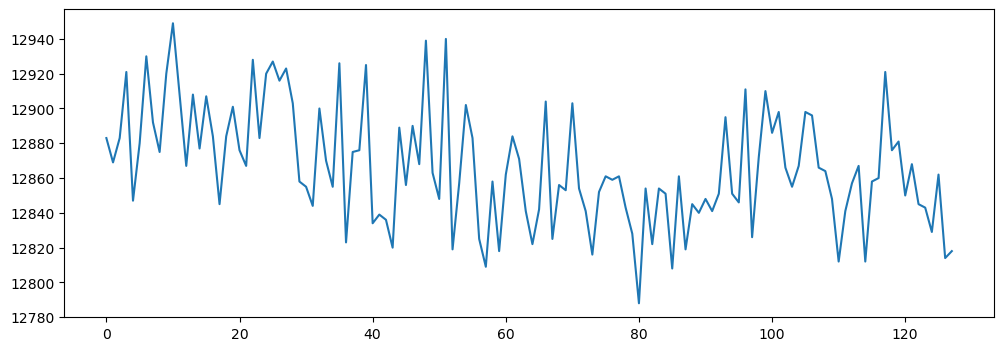

In [5]:

# Plot the BOLD signal timecourse of a random voxel
x, y, z = [31, 14, 7]
plt.figure(figsize=(12, 4))
plt.plot(np.transpose(bold.get_fdata()[x, y, z, :]))
plt.show()


In the plot above, what are the units of the x and y axes?

Below, make a new cell and plot the time series of a different voxel. Please add a label to the x-axis using the function plt.xlabel('YOUR_LABEL_HERE').


### Cleaning a BOLD Image

As you can see, the raw BOLD signal fluctuates quite a bit and you'll notice the y-axis range changes dependiing on the voxel (try changing the x, y, z coordinates in the plot above to see). To improve the signal-to-noise ratio, nilearn has a `clean_img` function that allows you to clean the data a bit before analyzing it.

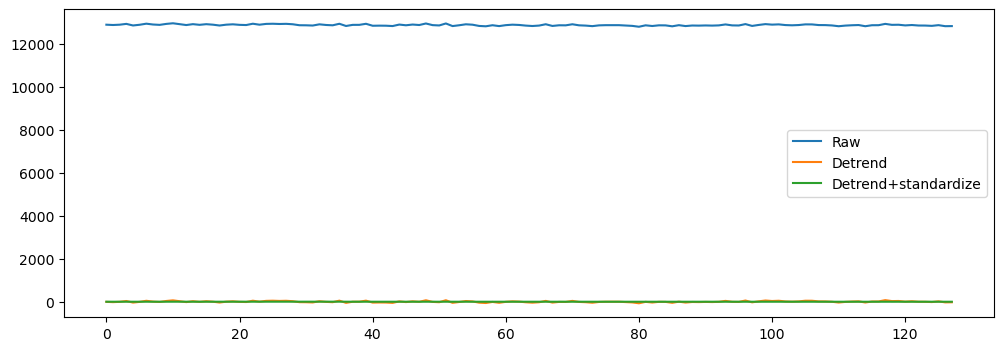

In [6]:
# don't worry about t_r for now. We will cover it below
t_r = 2.4

## Detrend the data
func_d = image.clean_img(bold, detrend=True, standardize=False, t_r=t_r)

## Detrend+Standardize the data
func_ds = image.clean_img(bold, detrend=True, standardize=True, t_r=t_r)


# plot the raw data alongside the cleaned data
plt.figure(figsize=(12, 4))
plt.plot(np.transpose(bold.get_fdata()[x, y, z, :]))
plt.plot(np.transpose(func_d.get_fdata()[x, y, z, :]))
plt.plot(np.transpose(func_ds.get_fdata()[x, y, z, :]))
plt.legend(['Raw','Detrend', 'Detrend+standardize']);


As you can see, the detrending and standardization changes the scale quite a bit. Let's now plot the two "clean" time series.

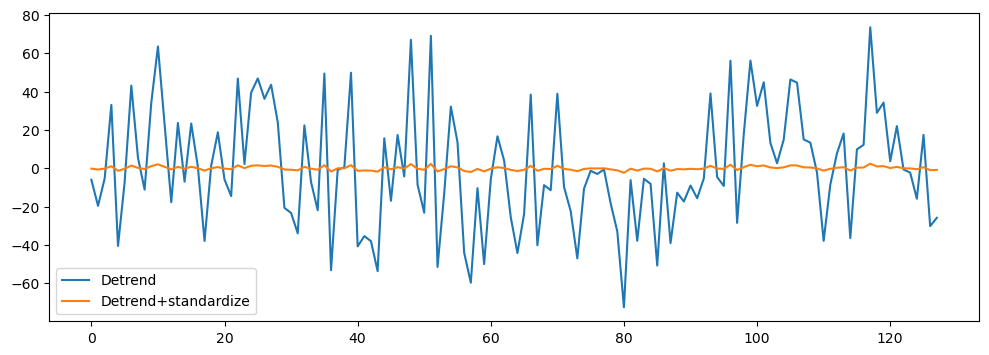

In [9]:
# plot the two cleaned time series
plt.figure(figsize=(12, 4))
plt.plot(np.transpose(func_d.get_fdata()[x, y, z, :]))
plt.plot(np.transpose(func_ds.get_fdata()[x, y, z, :]))
plt.legend(['Detrend', 'Detrend+standardize']);

## Problem 1:
Look back at the plot with only the raw data. How does that shape compare to the detrended data (blue line)? Why do you think that is? What do you think could affect the data so much?

(Your response here)

# Events File

Now that we've visualized the BOLD time series at both the voxel and whole-brain level, let's pivot to our events file so we can start to understand how the BOLD signal changes in response to different categories. As previously mentioned, this experiment involved 10 different conditions that required the participant to complete different tasks across different sensory modalities while in the scanner. As with all task-based fMRI studies, the information about these experimental conditions (e.g., when they occured) is stored in an events file. This file contains information about each individual trial including what experimental condition was being presented during that trial, when in the scan session did this trial occur, and how long did the trial last for. 

In [7]:
events_file = data["events"]
events = pd.read_table(events_file)

# Let's take a look at the first 5 trials present in our events file
events.head()

,trial_type,onset,duration
0,visual_computation,0.0,1.0
1,visual_computation,2.4,1.0
2,horizontal_checkerboard,8.7,1.0
3,audio_right_hand_button_press,11.4,1.0
4,sentence_listening,15.0,1.0


As you can see, we have three columns: `trial_type`, `onset`, and `duration`. `trial_type` gives us the type of trial, `onset` lets us know when in the scan this trial occurred, and `duration` lets us know how long each trial lasted (in units of seconds). 

Below please make a new cell and print all the conditions found in this study (this can be done using the `unique` function in `pandas`)

# First-level Model and Design Matrix

Nilearn has a function called `FirstLevelModel` that will serve as the starting point for combining the events file and BOLD data in our analysis. Briefly, this function fits a linear model that uses the information in the events file to predict the BOLD signal over the course of the scan session. Among other things, this function generates what's known as a design matrix, which enables us to see which condition was being presented at a given moment during the scan. 

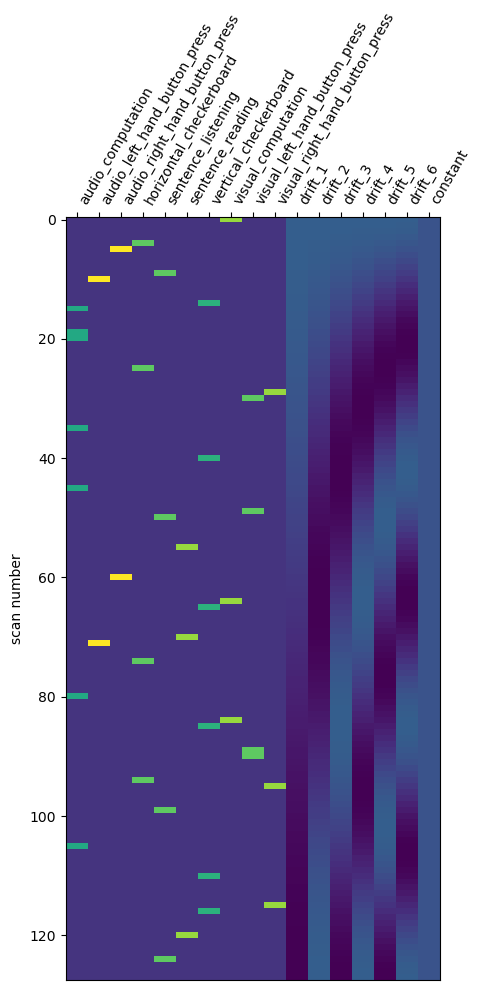

In [8]:
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel

t_r = 2.4
# Fit first level model with no HRF -- set signal_scaling to False so predictions are on same scale as observed
first_level_model_no_hrf = FirstLevelModel(t_r,hrf_model=None, signal_scaling=False,
                                           mask_img=False,minimize_memory=False)

first_level_model_no_hrf_fit = first_level_model_no_hrf.fit(func_ds, events=events)

# Grab the desing matrix and plot
plot_design_matrix(first_level_model_no_hrf_fit.design_matrices_[0])

plt.show()

Each row of this matrix represents a volume and the columns represent either the experimental conditions (first 10 columns) or drifts that impact the bold signal. Dark blue means that a particular entry in the matrix is 0 and the other colors represent a 1 (i.e. when a particular condition was being presented in the scanner).  

### Evaluating the Model

We can then generate predictions from our first level model and compare those to the observed BOLD signal from our scan.

In [18]:
# preds=image.load_img(first_level_model_no_hrf.fit(func_ds, events=events).predicted)

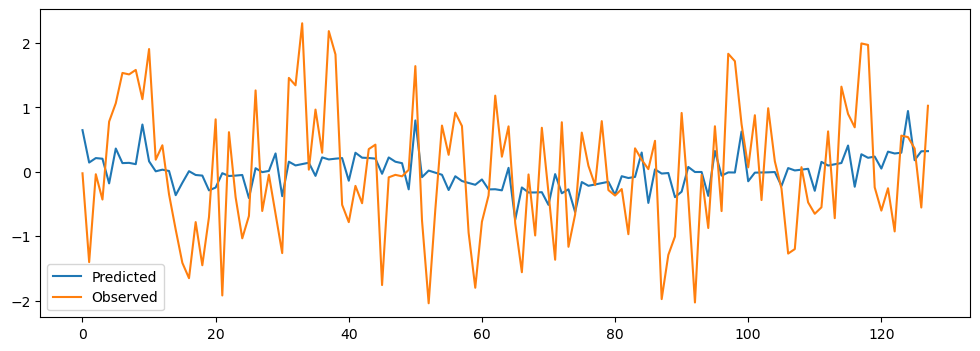

In [11]:
# Get predictions generated from our first level model
preds = image.load_img(first_level_model_no_hrf_fit.predicted)

x, y, z = [36, 28, -9]
plt.figure(figsize=(12, 4))

# plot predicted data
plt.plot(np.transpose(preds.get_fdata()[x, y, z, :]))
    
# plot observed data
plt.plot(np.transpose(func_ds.get_fdata()[x, y, z, :]))
plt.legend(['Predicted', 'Observed']);

           
plt.show()

### The Hemodynamic Response Function (HRF)

As you can see, the time series we modeled deosn't quite capture the observed BOLD time series. This is in large part because when a neural event occurs it does not cause a rapid peak in the BOLD signal, but rather leads to a slow response that evolves over time

We know roughly how the vascular response measured by BOLD evolves over time. This means that when there is an event that stimulates a brief neural response (any one of our experimental conditions, for example), the resulting BOLD signal will change in a predictable way. We call this the hemodynamic response function (HRF). 

Nilearn comes with a couple different options for HRFs that you can use to incorporate into your analysis. The cell below provides an example of what these HRFs look like. Based on their shape relative to the stimulus onset, are there questions that are not suitable for this method of analysis?

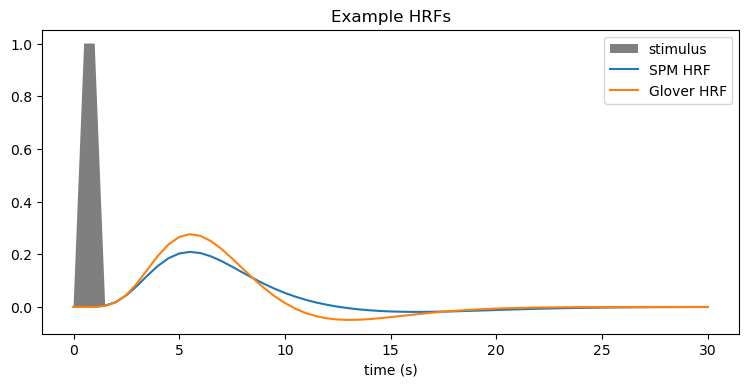

In [12]:
## Adapted from: https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_hrf.html

from nilearn.glm.first_level import compute_regressor

## setup info about stimulus and experiment
time_length = 30.0
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude

oversampling = 16

rf_models = [
    ("spm", "SPM HRF"),
    ("glover", "Glover HRF"),
]

fig = plt.figure(figsize=(9, 4))
plt.fill(frame_times, stim, "k", alpha=0.5, label="stimulus")

for i, (rf_model, model_title) in enumerate(rf_models):
    # compute signal of interest by convolution
    signal, _labels = compute_regressor(
        exp_condition,
        rf_model,
        frame_times,
        con_id="main",
        oversampling=oversampling,
    )

    for j in range(signal.shape[1]):
        plt.plot(
            frame_times,
            signal.T[j],
            label=model_title,
        )
    plt.xlabel("time (s)")
    plt.legend(loc=1)
    plt.title("Example HRFs")

# adjust plot
plt.subplots_adjust(bottom=0.12)
plt.show()

We can incorporate the hemodynamic response function into our design matrix by "convolving" each event with the HRF. This is accomplished using the `hrf_model` parameter in the `FirstLevelModel` function. When we do this, the regressors are now smoothed in time to match the typical hemodynamic response rather than being represented by a brief spike. When we plot the design matrix, notice how the events have been smoothed based on the HRF. How does the predicted time series differ between the model that includes the HRF and the one that does not?

### Plot the new design matrix that includes the HRF

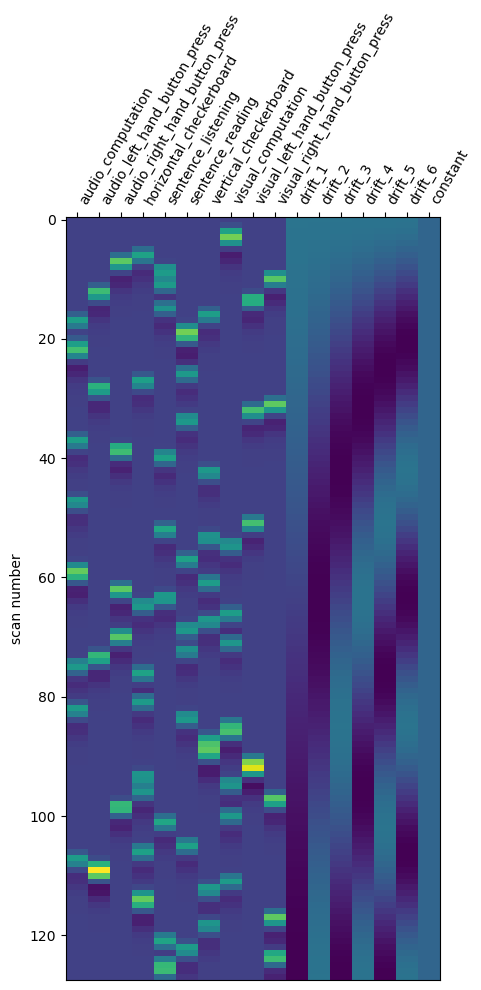

In [16]:
# Fit first level model with HRF
first_level_model_hrf = FirstLevelModel(t_r,hrf_model='glover',signal_scaling=False,
                                      mask_img=False,minimize_memory=False)
first_level_model_hrf = first_level_model_hrf.fit(func_ds, events=events)

# Grab the desing matrix and plot
design_matrix = first_level_model_hrf.design_matrices_[0]
plot_design_matrix(design_matrix)

plt.show()



### And plot the predicted data that uses the HRF

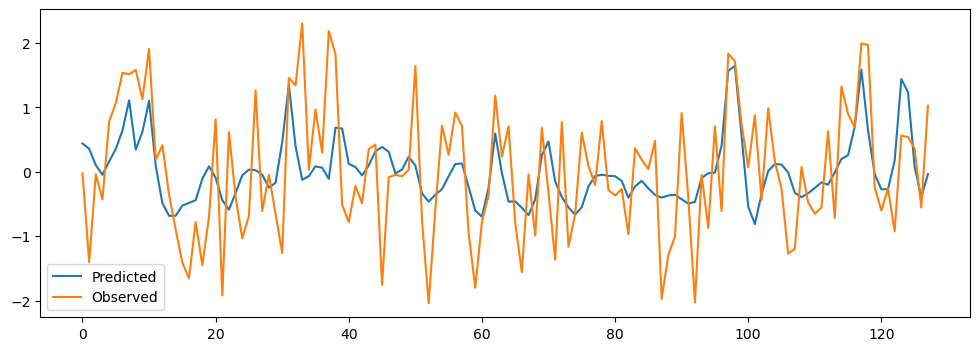

In [17]:
# Get predictions generated from our first level model
preds = image.load_img(first_level_model_hrf.predicted)

x, y, z = [36, 28, -9]
plt.figure(figsize=(12, 4))

# plot predicted data
plt.plot(np.transpose(preds.get_fdata()[x, y, z, :]))
    
# plot observed data
plt.plot(np.transpose(func_ds.get_fdata()[x, y, z, :]))
plt.legend(['Predicted', 'Observed']);

           
plt.show()

# Computing Contrasts

Now that we've fit our model to predict the BOLD signal, we can then use it to compare how the brain response differs between our various experimental contrasts. In this example, we will focus on how visual and audio computation differ from one another. Our first step is to set up a contrast dictionary, which will enable us to directly compare experimental conditions. By using numpy arrays, we can easily combine conditions using addition or contrast conditions usinig subtraction.

In [18]:
# use design matrix to set up contrasts
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

Just to make sure we are setting up our contrast correctly, we can use the function `plot_contrast_matrix`. You can pass your contrast and design matrix into this function and it will plot your contrast. The reference condition (in this case `audio_computation` will show up as a white square and the condition you've subtracted in your contrast (in this case `visual_computation`) will show up as a black square. The experimental conditions that we are ignoring in this analysis will show up as grey. 

<Axes: label='conditions'>

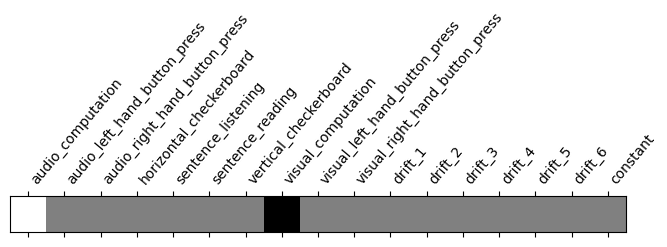

In [19]:
# subtract visual_computation from audio_computation
aud_minus_vis = contrasts["audio_computation"]-contrasts['visual_computation']

# plot contrast matrix
plot_contrast_matrix(aud_minus_vis, design_matrix)



Once we've set up our contrast, we can use the `compute_contrast` method to generate a statistical map of the difference in the BOLD signal across the conditions specified in our contrast. Briefly, for each voxel this function computes a z-score for the `audio_computation`-`visual_computation` contrast. We can then threshold our statistical map (in this case we use a threshold of 3) and plot voxels that have a z-value of greater than 3 (or -3). The voxels with red/orange coloring are those where `audio_computation` resulted in a stronger BOLD signal compared to `visual_computation` and blue voxels are those where `visual_computation` resulted in a stronger BOLD response. Looking at the visualization, do the brain areas that show a stronger response to audio or visual stimuli make sense to you? 

/Users/jamiel12/miniconda3/lib/python3.11/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


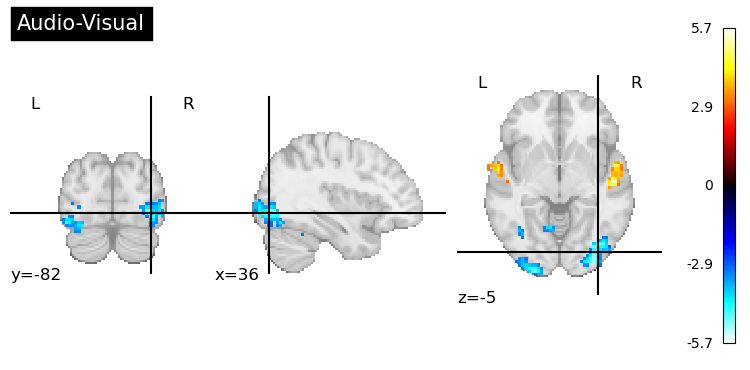

In [20]:
from nilearn.plotting import plot_stat_map

# compute the statistical map using our contrast
z_map = first_level_model_hrf.compute_contrast(
    aud_minus_vis, output_type="z_score"
)

# Grab clusters of voxels that exceed a specific z-threshold and cluster size
cluster_img = image.threshold_img(z_map, threshold=3.0, cluster_threshold=20)

# splot our stat map
av_stat_map = plot_stat_map(
    cluster_img,
    title="Audio-Visual",
)

## Problem 2: Compute your own contrast

Below please compare two (or more) conditions usinig the approach outlined above. Generate a couple of plots highlighting your contrast and provide a few sentences interpreting these plots.

In [21]:
# Your code here

# MRI Decoding

Computing contrasts and plotting the differences in BOLD activation between two experimental conditions is one way of analyzing MRI data, though many of the decisions used in this approach (cluster size, z-threshold) can be somewhat arbitrary. Another way of analyzing fMRI data is MRI decoding, where we train a classifier on different activation patterns to predict whether a participant was experiencing one condition vs another. In this example, we will stick to our analysis of `audio_computation` vs `visual_computation` and see if we can train a model to classify these two experimental conditions.

## Setting up our data

To start, we need to mask both our design matrix and fMRI data so that it only includes information from the relevant experimental conditions.

In [22]:

# grab our design matrix columns from the non-HRF model for our two conditions and flag whether 
# or not they are not 0 in a given row (meaning this condition was being 
# presented during the acquisition of that particular volume)
av_cols = design_matrix[['audio_computation', 'visual_computation']]!=0

# generate a mask based on whether audio_computation or visual_computation was being presented
condition_mask = np.array((av_cols['audio_computation']==True)|(av_cols['visual_computation']==True))

# generate list of conditions based on our av_cols
conditions = ['audio_computation' if av_cols.iloc[i,]['audio_computation'] == 1 else 'visual_computation' if av_cols.iloc[i,]['visual_computation'] else 'other' for i in range(0, len(av_cols))]
conditions = np.array(conditions)

Note that the length of our conditions list and condition_mask match with the 4th dimension of our fMRI data. This is important when using a mask to filter irrelevant data from our BOLD timeseries.

In [24]:
print(len(conditions))
print(len(condition_mask))
print(func_ds.shape)

128
128
(53, 63, 46, 128)


Nilearn has a convenient function called `index_img` that allows us to filter our fMRI data using our condition mask and generate an new image that only contains data for the experimental conditions we are interested in. Notice how the shape of our masked image has changed. Why do you think that is?

In [25]:
# mask our standardized bold image using our conditions_mask
func_ds_masked = image.index_img(func_ds, condition_mask)

# mask our conditions list using our conditions_mask
conditions_masked = conditions[condition_mask]

# note how the length of our masked conditions and 4th dimension of our masked file still match
print(func_ds_masked.shape)
print(len(conditions_masked))

(53, 63, 46, 121)
121


## Training the Classifier

Now that we've masked our conditions and functional data, we are ready to train our machine learning classifier to see if we can correctly classify our experimental contrasts based on the fMRI data. It should be noted that we only have 10 instances of either `visual_computation` or `audio_computation` in our experiment. In a real study, we would ideally have more observations of each category so that we can generate a training and validation set from our data as well as use more robust cross-validation when training our model. 

Training our classifier on voxels from across the brain can be computationally expensive. We will try to get around this by focusing our decoding example only on the voxels that showed large differences between our two conditions. To do this, we can generate a binary mask based on the areas we identified in the contrast example.

In [26]:
from nilearn.maskers import NiftiMasker

masker = NiftiMasker(mask_img=cluster_img)
mask = image.math_img('abs(img) > 0', img=masker.mask_img)

Nilearn is highly integrated with the `scikit-learn` library and therefore access to many different machine learning models that you can use in your decoding analysis. For this example, we use the default support vector classifier but a full list of options can be found here: https://nilearn.github.io/dev/modules/generated/nilearn.decoding.Decoder.html#nilearn.decoding.Decoder

In [27]:
from nilearn.decoding import Decoder

# set up our Decoder and pass our cluster mask
decoder = Decoder(
    estimator="svc", mask=mask,standardize="zscore_sample", cv=3, scoring='accuracy'
)

# fit our decoder model on the masked data and conditions
# for this method, the first argument is your predictors (MRI data) and 
# and the second argument are your target variables (experimental condition)
decoder.fit(func_ds_masked, conditions_masked)

Once we train our model, we can then look at the predictions and see how well the model did. Since we did not have enough data to create a training and validation set, the model is perfectly accurate but we do not have any idea on how it will perform on data it hasn't been trained on.   

In [28]:
prediction = decoder.predict(func_ds_masked)
print("Predictions:")
print(prediction)

print("Observed:")
print(conditions_masked)

print((prediction == conditions_masked).sum() / float(len(conditions_masked)))

Predictions:
['visual_computation' 'visual_computation' 'visual_computation'
 'visual_computation' 'visual_computation' 'visual_computation'
 'visual_computation' 'visual_computation' 'visual_computation'
 'visual_computation' 'visual_computation' 'visual_computation'
 'visual_computation' 'visual_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computation'
 'audio_computation' 'audio_computation' 'audio_computatio

One interesting thing about the Decoder object is that it stores the model weights in a format that can be easily plotted with nilearn. This enables us to see which brain areas were important in driving the predictions of each category. By running the cell below, we can see the areas that were important in classifying the `audio_computation` condition.

/Users/jamiel12/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



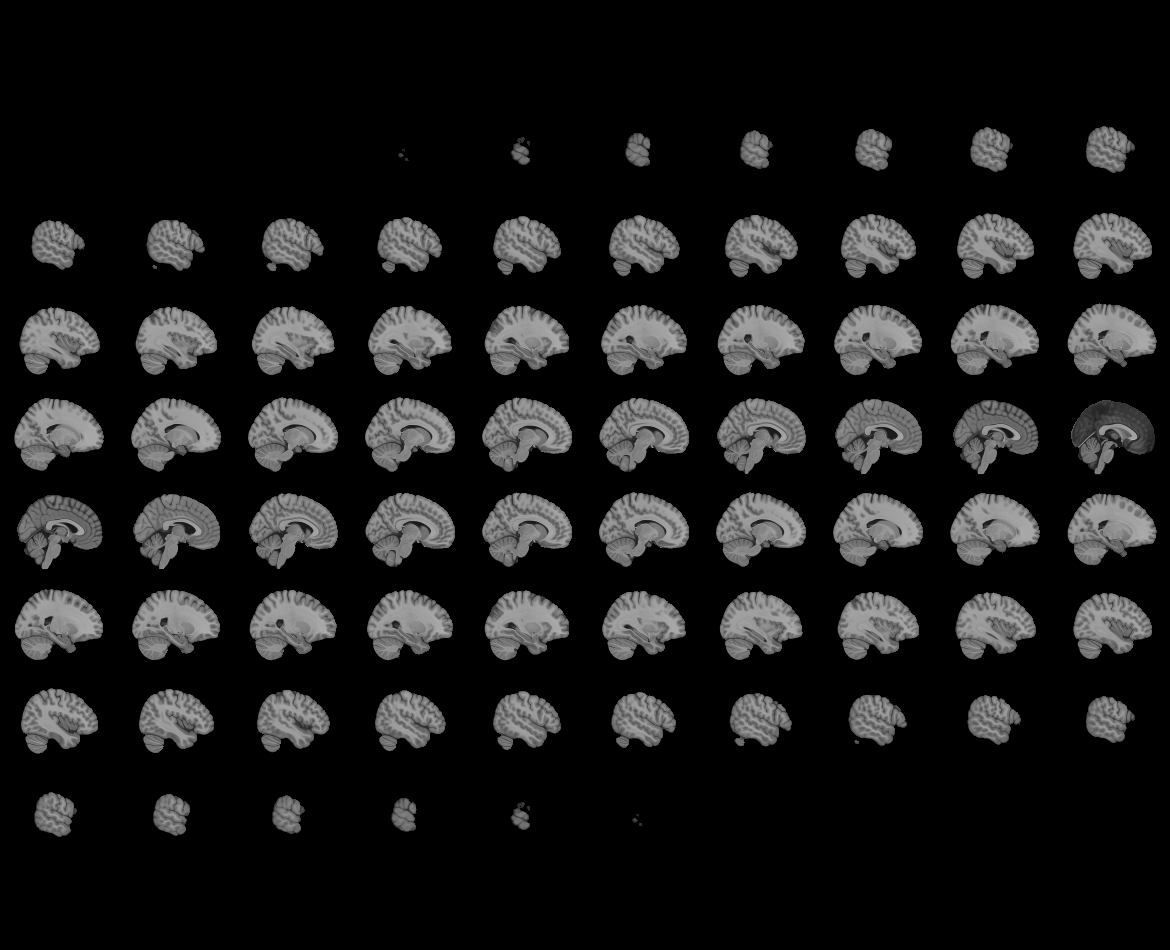
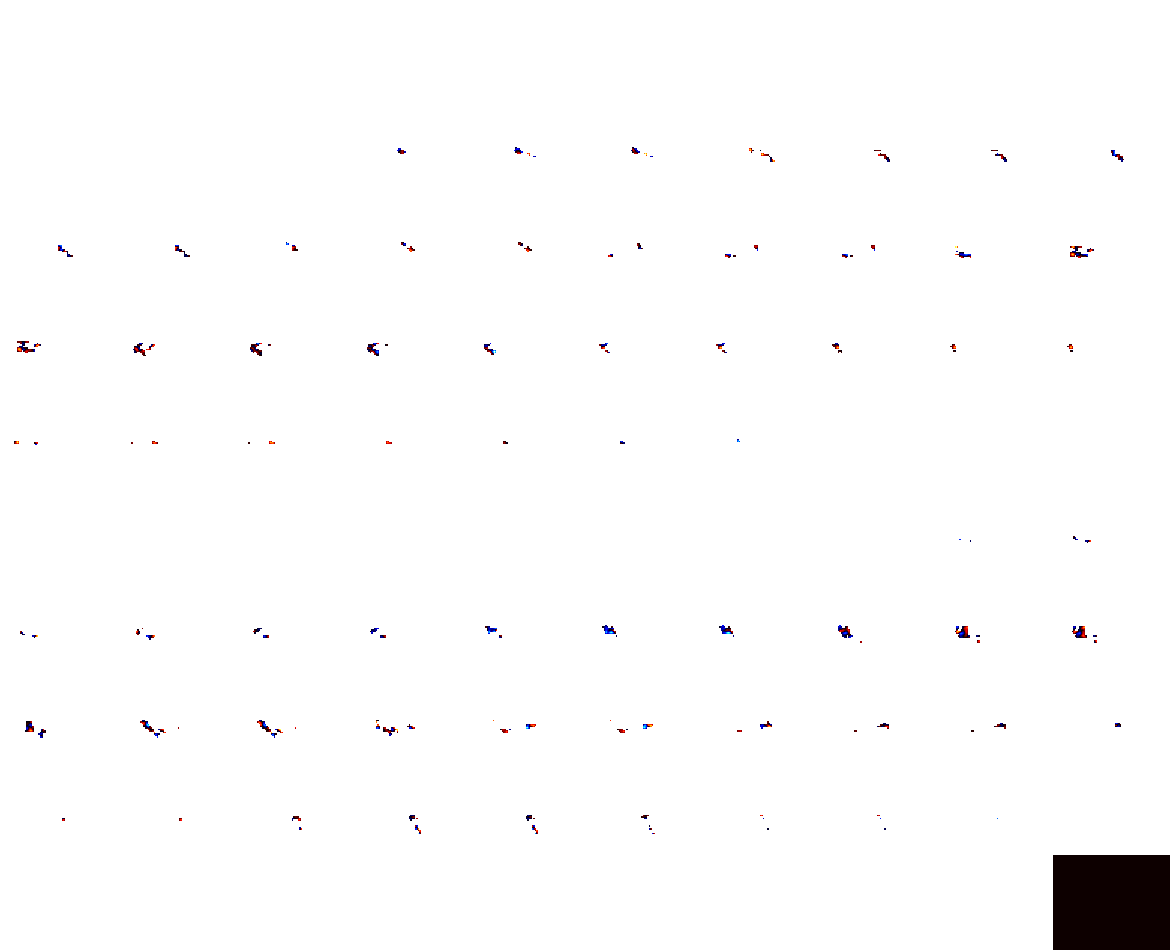

In [29]:
plotting.view_img(
    decoder.coef_img_["audio_computation"]
)

## Problem 3: Plot another condition
Add another cell and plot the `visual_computaiton condition`. How do these two maps compare with one another? 

In [30]:
# Your code here

## Problem 4
What are the benefits to computing contrasts and what are the benefits to decoding apporaches? Why would you use one approach versus the other? Give an example for why you would use each apporach and what it can tell us about data.

(Your response here)

## Problem 5: Do it all again
Now that you've completed this tutorial, choose a different dataset from nilearn and run your own analysis on that data. You can choose either to compute contrasts or to use a decoding apporach. Make sure to give a quick description of the data you choose, the analysis approach you choose, and explain what the results show. Provide plenty of commentary to inerpret the results to demonstrate your understanding of the topic.

In [31]:
# begin your analysis here